# Preliminary Data Analysis

Some preliminary data analysis on the data acquired during regen testing on July 6th, between 22:02 and 22:04 (PST).
This notebook takes advantage of the custom `TimeSeries` class, which is a data-analysis centric wrapper around `np.ndarray`.

In [20]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient
import datetime
from simulation.common import BrightSide

import matplotlib.pyplot as plt
import numpy as np

# 1st Run
start = "2024-07-07T05:02:19Z"
stop = "2024-07-07T05:04:04Z"

client = InfluxClient()

In [32]:
def create_timeseries():
    # Example data loading (replace with your actual data loading logic)
    start_time = datetime.datetime(2024, 1, 1, 0, 0, 0)
    end_time = start_time + datetime.timedelta(seconds=3600)  # 1 hour interval
    granularity = 1.0  # seconds

    # Simulated data for illustration
    time_axis = np.linspace(0, (end_time - start_time).total_seconds(), num=3600, endpoint=False)
    pack_voltage = np.sin(time_axis * 2 * np.pi / 3600) * 20 + 380
    pack_current = np.sin(time_axis * 2 * np.pi / 3600) * 5 - 2
    vehicle_velocity = np.ones_like(time_axis) * 25

    # Example metadata
    meta_pack_voltage = {
        "start": start_time,
        "stop": end_time,
        "units": "V",
        "granularity": granularity,
        "length": (end_time - start_time).total_seconds(),
        "measurement": "Battery",
        "field": "Pack Voltage",
        "car": "Brightside",
    }
    meta_pack_current = {
        "start": start_time,
        "stop": end_time,
        "units": "A",
        "granularity": granularity,
        "length": (end_time - start_time).total_seconds(),
        "measurement": "Battery",
        "field": "Pack Current",
        "car": "Brightside",
    }
    meta_vehicle_velocity = {
        "start": start_time,
        "stop": end_time,
        "units": "km/h",
        "granularity": granularity,
        "length": (end_time - start_time).total_seconds(),
        "measurement": "Vehicle",
        "field": "Velocity",
        "car": "Brightside",
    }

    # Create TimeSeries objects
    ts_pack_voltage = TimeSeries(pack_voltage, meta_pack_voltage)
    ts_pack_current = TimeSeries(pack_current, meta_pack_current)
    ts_vehicle_velocity = TimeSeries(vehicle_velocity, meta_vehicle_velocity)

    return ts_pack_voltage, ts_pack_current, ts_vehicle_velocity

Query the data, then align their x–axes such that math is well-defined.

In [33]:
# pack_voltage: TimeSeries = client.query_time_series(start, stop, "TotalPackVoltage", units="V")
# pack_current: TimeSeries = client.query_time_series(start, stop, "PackCurrent", units="A")
# vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
# pack_current, pack_voltage, vehicle_velocity = TimeSeries.align(pack_current, pack_voltage, vehicle_velocity)

# # Subtract LVS current from pack current
# pack_current -= BrightSide.lvs_current

pack_voltage, pack_current, vehicle_velocity = create_timeseries()

Plot the data to make sure nothing bad or spooky happened (and matches what's seen on InfluxDB Data Explorer).

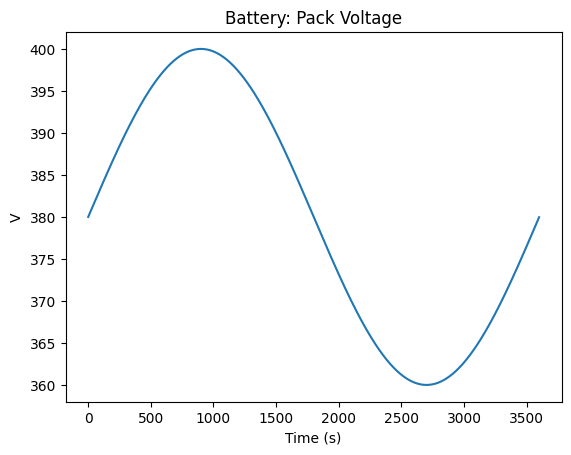

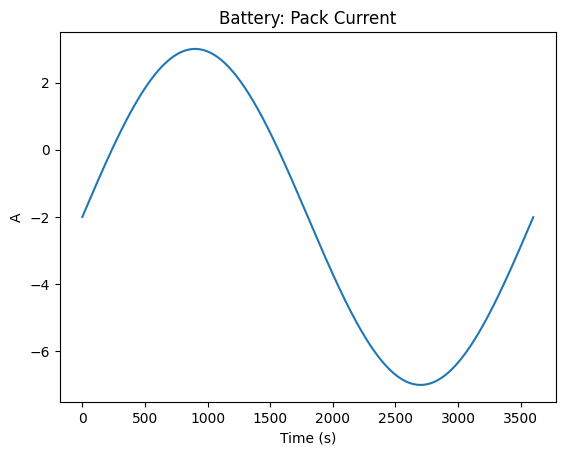

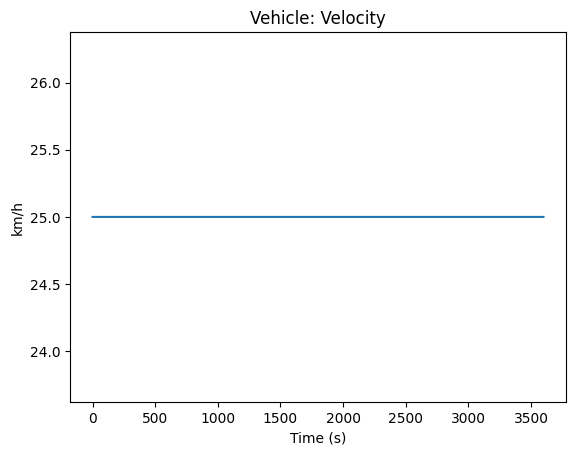

In [34]:
pack_voltage.plot(False)
pack_current.plot(False)
vehicle_velocity.plot(False)
plt.show()

Now, let's find the time that current is negative (regen is occurring).

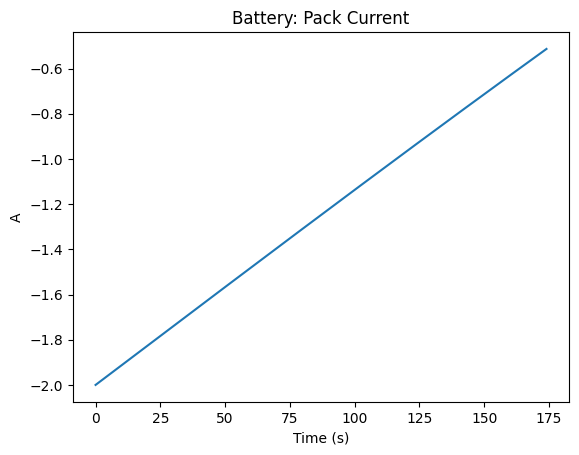

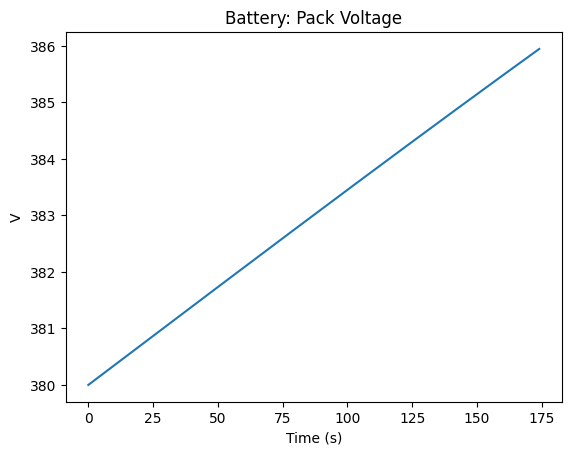

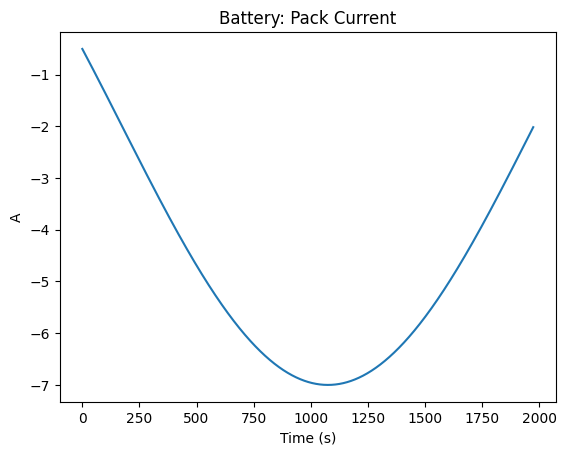

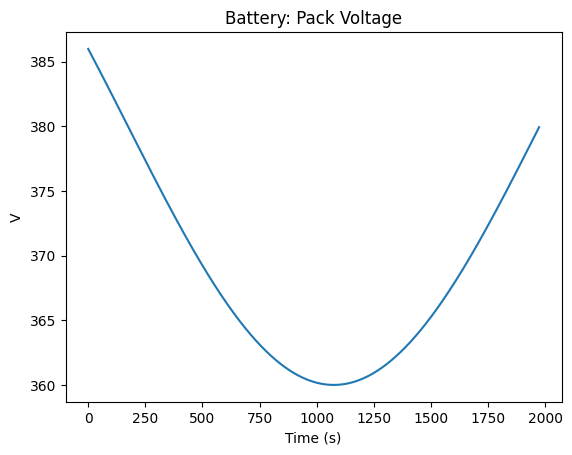

In [35]:
# Find indices where regen occurs
current_negative_mask = np.where(pack_current < -0.5)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = pack_current[first_regen_index:last_regen_index]
    regen_voltage = pack_voltage[first_regen_index:last_regen_index]
    regen_current.plot(show=False)
    regen_voltage.plot(show=False)
    plt.show()

We can also inspect the change in velocity to get a sense of the change in kinetic energy, estimating a vehicle mass of 300kg.

In [36]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

for period in regen_periods:
    initial_velocity = vehicle_velocity[first_regen_index]                              # Units: m/s
    final_velocity = vehicle_velocity[last_regen_index]                                 # Units: m/s
    kinetic_energy  = lambda vi, vf: 0.5 * BrightSide.vehicle_mass * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    print(f"Initial Velocity for Period {period_index}: {initial_velocity:.4f} {vehicle_velocity.units}")
    print(f"Final Velocity for Period {period_index}: {final_velocity:.4f} {vehicle_velocity.units}")
    print(f"Change in Kinetic Energy for Period {period_index}: {delta_kinetic_energy:.4f} J")

    period_index += 1

Initial Velocity for Period 1: 25.0000 km/h
Final Velocity for Period 1: 25.0000 km/h
Change in Kinetic Energy for Period 1: -0.0000 J
Initial Velocity for Period 2: 25.0000 km/h
Final Velocity for Period 2: 25.0000 km/h
Change in Kinetic Energy for Period 2: -0.0000 J


Now, let's calculate the battery power during regen.
Note: the elementwise-array multiplication returns an `ndarray`, so I use `regen_current.promote()` on the result to get back a `TimeSeries`.

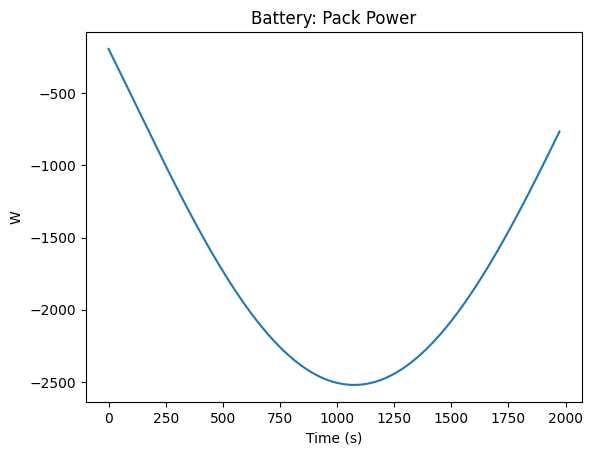

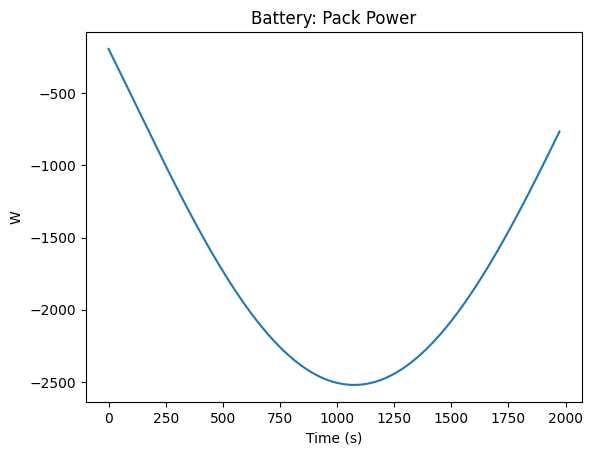

In [26]:
for period in regen_periods:  
    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"
    regen_power.plot()

Now, let's integrate with respect to time to get regen energy, and then get efficiency.

In [37]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

for period in regen_periods:
    regen_energy = np.trapz(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    print(f"Regen Energy for Period {period_index}: {regen_energy:.3f} J")
    print(f"Regen Efficiency for Period {period_index}: {efficiency * 100:.2f}%")

    period_index += 1

Regen Energy for Period 1: -3493565.318 J
Regen Efficiency for Period 1: inf%
Regen Energy for Period 2: -3493565.318 J
Regen Efficiency for Period 2: inf%


C:\Users\miche\AppData\Local\Temp\ipykernel_6184\1480833557.py:5: RuntimeWarning: divide by zero encountered in divide
  efficiency: float = regen_energy / delta_kinetic_energy
